# Explainability

This notebook uses **SHAP (SHapley Additive exPlanations)** to interpret the Health Risk Scoring model and understand which features most influence CHD predictions. SHAP identifies key risk drivers—such as age, blood pressure, cholesterol, and glucose—and shows how each contributes to individual patient risk scores. These explanations ensure the model remains transparent, interpretable, and consistent with established medical knowledge.

# 1. General Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression


In [2]:
# Initialize SHAP
shap.initjs()

# 2. Load Data and Recreate Splits

This is the exact process used in the `modelng.ipynb`.

In [3]:
# Load the data
df = pd.read_csv('../data/raw/framingham_heart_study.csv');
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
# Create the features and target
target = 'TenYearCHD'
X = df.drop(columns = [target])
y = df[target]

In [5]:
## Create the train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

print(f'Train set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

Train set shape: (3392, 15)
Test set shape: (848, 15)


In [6]:
# Specify numeric and categorical columns
numeric_columns = X_train.select_dtypes(include = [np.number]).columns.tolist()

print(f'Numeric columns: {numeric_columns}')

Numeric columns: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']


# 3. Load Saved Best Model

The best model pipeline (`Logistic Regression`) was saved under `models/health_risk_model.joblib`. Load it.

In [7]:
# Load the saved best model
import joblib

log_reg_model = joblib.load('../models/health_risk_model.joblib')
log_reg_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['male', 'age', 'education',
                                                   'currentSmoker',
                                                   'cigsPerDay', 'BPMeds',
                                                   'prevalentStroke',
                                                   'prevalentHyp', 'diabetes',
                                                   'totChol', 'sysBP', 'diaBP',
                                                   'BMI', 'heartRate',
                                                   'glucose'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=42))])

# 4. Get Feature Names After Preprocessing

To interpret SHAP values, we need to know which transformed columns correspond to which features.

In [8]:
# Get feature names
preprocessor = log_reg_model.named_steps['preprocessor']

# The dataset only has numeric features
feature_names = numeric_columns
feature_names

['male',
 'age',
 'education',
 'currentSmoker',
 'cigsPerDay',
 'BPMeds',
 'prevalentStroke',
 'prevalentHyp',
 'diabetes',
 'totChol',
 'sysBP',
 'diaBP',
 'BMI',
 'heartRate',
 'glucose']

# 5. Build the SHAP Explainer

For logictic regression on transformed data, we use `LinearExplainer`.

In [9]:
# First, transform `X_train` to the transformed feature space
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Next, create the explainer
classifier = log_reg_model.named_steps['classifier']

explainer = shap.LinearExplainer(
    classifier,
    X_train_proc,
    feature_names = feature_names
)

# Next, use a sample of the processed training data for global explanation
X_train_sample = X_train_proc if X_train_proc.shape[0] <= 2000 else X_train_proc[:2000]
shap_values = explainer(X_train_sample)

# 6. Create a Summary Plot of Global Feature Importance

First, let's create a SHAP plot for global feature importance.

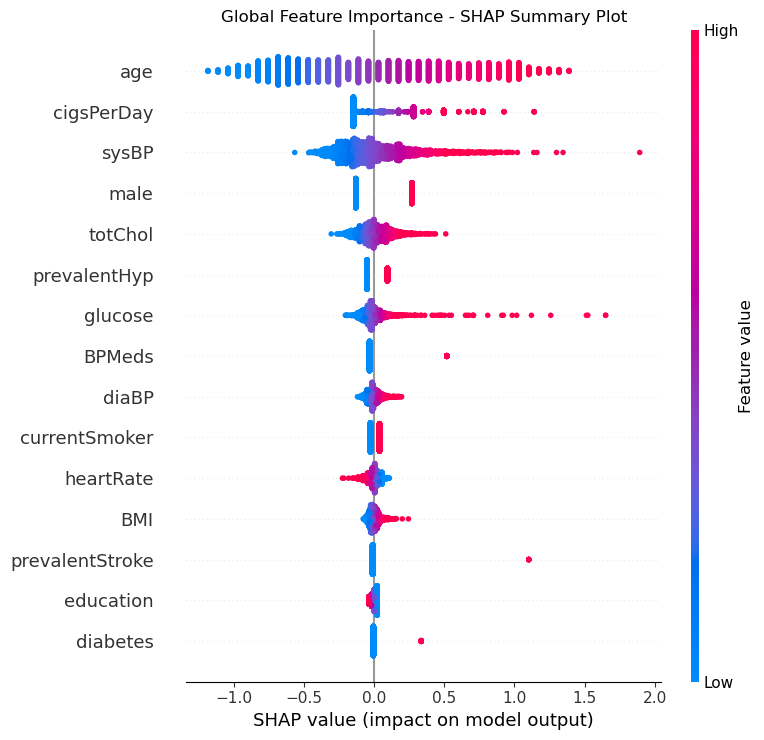

In [15]:
# Create a summary plot of global feature importance
plt.figure(figsize = (10, 50))
shap.summary_plot(shap_values, X_train_sample, feature_names = feature_names, show = False)
plt.title('Global Feature Importance - SHAP Summary Plot')
plt.tight_layout()
plt.savefig('../images/shap-summary-plot.png')
plt.show()

**Intrepretation:**
- The SHAP summary plot highlights **age**, **smoking intensity (`cigsPerDay`)**, **systolic blood pressure (`sysBP`)**, **sex**, **total cholesterol (`totChol`)**, and **glucose** as the most influential drivers of the model’s CHD risk predictions.
- Positive SHAP values show that higher values for these features push the model toward predicting greater risk, while negative SHAP contributions indicate reduced risk.
- These relationships closely mirror known clinical risk factors, increasing confidence that the model is behaving in a medically consistent and interpretable manner.

Next, let's create a bar summary of the mean absolute value per feature

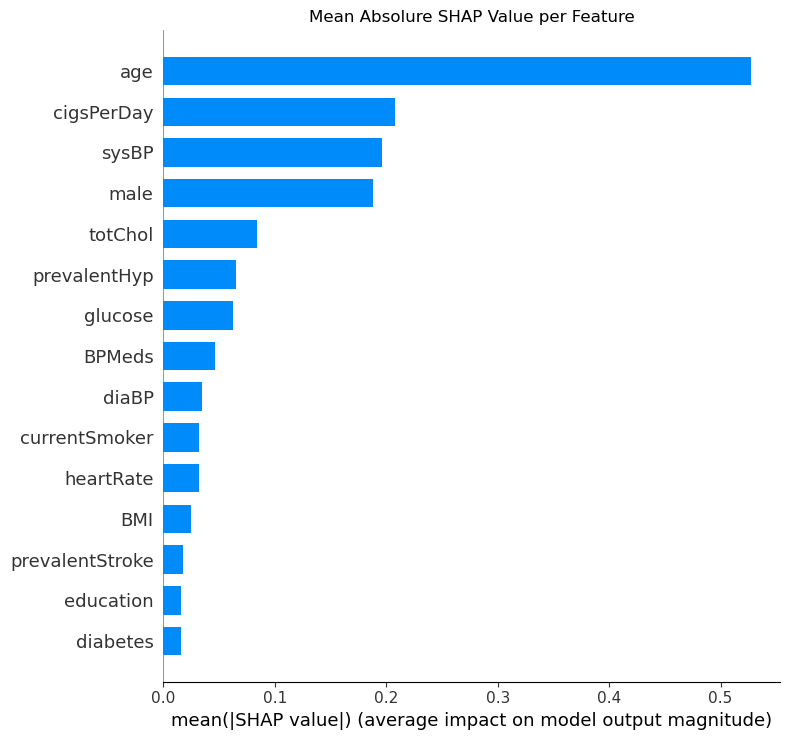

In [18]:
# Create a bar summary of the mean absolkute value oer feature
plt.figure(figsize = (8, 5))
shap.summary_plot(shap_values, X_train_sample, feature_names = feature_names, plot_type = 'bar', show = False)
plt.title('Mean Absolure SHAP Value per Feature')
plt.tight_layout()
plt.savefig('../images/shap-mean-absolute-value-plot.png')
plt.show()

# 7. Provide Comparative Expanations for Two Patient Types

Pick the following patient types and provide local explanations for their diagnostic:
- One patient with `TenYearCHD = 1` (postive class)
- One patient with `TenYearCHD = 0` (negative class)

In [34]:
# Add predictions to X_test for easier selection
X_test_with_target = X_test.copy()
X_test_with_target[target] = y_test.values

# Select the samples
high_risk_case = X_test_with_target.query('TenYearCHD == 1').iloc[0]
low_risk_case = X_test_with_target.query('TenYearCHD == 0').iloc[0]

print(f'High risk case: \n{high_risk_case}')
print(f'\nLow risk case: \n{low_risk_case}\n')

High risk case: 
male                 1.00
age                 64.00
education            1.00
currentSmoker        0.00
cigsPerDay           0.00
BPMeds               0.00
prevalentStroke      0.00
prevalentHyp         0.00
diabetes             0.00
totChol            296.00
sysBP              142.00
diaBP               84.00
BMI                 27.01
heartRate           52.00
glucose             83.00
TenYearCHD           1.00
Name: 1939, dtype: float64

Low risk case: 
male                 0.00
age                 46.00
education            1.00
currentSmoker        0.00
cigsPerDay           0.00
BPMeds               0.00
prevalentStroke      0.00
prevalentHyp         0.00
diabetes             0.00
totChol            325.00
sysBP              119.00
diaBP               86.00
BMI                 35.13
heartRate           68.00
glucose             64.00
TenYearCHD           0.00
Name: 3996, dtype: float64



In [44]:
# Transform the samples
high_risk_proc = preprocessor.transform(high_risk_case.to_frame().T)
low_risk_proc = preprocessor.transform(low_risk_case.to_frame().T)

# Explain the processed samples
shap_high  = explainer(high_risk_proc)
shap_low = explainer(low_risk_proc)

In [45]:
# Now create a SHAP plot for each use case
shap.plots.force(shap_high[0])

**Interpretation**:

For the high-risk patient, the model’s prediction is driven upward by older age, higher systolic blood pressure, and elevated cholesterol.

In [46]:
shap.plots.force(shap_low[0])

**Interpretation**:

For the low-risk patient, younger age and more favorable clinical values contribute negative SHAP values, pulling the risk score down.

# 8. Add Simple Risk Tiers

In [51]:
y_prob = log_reg_model.predict_proba(X_test)[:,1]

def risk_tier(p):
    if p < 0.20:
        return 'Low'
    elif p < 0.50:
        return 'Medium'
    else:
        return 'High'

risk_tiers = [risk_tier(p) for p in y_prob]

X_test_with_risk = X_test.copy()
X_test_with_risk[target] = y_test.values
X_test_with_risk['PredictedRisk'] = y_prob
X_test_with_risk['RiskTier'] = risk_tiers

X_test_with_risk.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,PredictedRisk,RiskTier
3996,0,46,1.0,0,0.0,0.0,0,0,0,325.0,119.0,86.0,35.13,68.0,64.0,0,0.286258,Medium
1593,0,39,3.0,1,3.0,0.0,0,0,0,186.0,114.0,77.0,21.01,80.0,85.0,0,0.141152,Low
1272,0,56,3.0,0,0.0,0.0,0,1,0,186.0,155.0,102.0,24.38,81.0,75.0,0,0.492176,Medium
3772,1,39,2.0,1,10.0,0.0,0,0,0,215.0,102.0,64.5,24.50,68.0,62.0,0,0.197258,Low
821,0,55,1.0,0,0.0,0.0,0,1,0,305.0,168.0,82.0,26.45,72.0,78.0,0,0.592224,High


array([0.28625846, 0.14115194, 0.49217553, 0.19725822, 0.5922241 ,
       0.26285515, 0.16763011, 0.57122579, 0.10909188, 0.74099029,
       0.3145328 , 0.23100202, 0.17363232, 0.11237065, 0.37634111,
       0.44997726, 0.40623644, 0.24344455, 0.15224123, 0.68159161,
       0.20948757, 0.51280693, 0.28891702, 0.38964094, 0.30286721,
       0.58101195, 0.36608509, 0.45003049, 0.21643908, 0.6442498 ,
       0.44435045, 0.68542933, 0.64520805, 0.64861607, 0.19865035,
       0.51422794, 0.43790514, 0.28742116, 0.66426337, 0.33791311,
       0.73654156, 0.34278227, 0.3549282 , 0.20346674, 0.45021315,
       0.57646944, 0.16721317, 0.64505598, 0.41729976, 0.45261476,
       0.24930144, 0.33647196, 0.68688279, 0.56169959, 0.40023174,
       0.18141697, 0.8921623 , 0.09684319, 0.39251604, 0.20150778,
       0.67309274, 0.52760967, 0.90613677, 0.79212184, 0.28833504,
       0.49884752, 0.61999811, 0.38824117, 0.57700561, 0.34343365,
       0.2491965 , 0.44844591, 0.3904715 , 0.49929185, 0.23373